# Telco Churn

## Project Goals
* Identify drivers of churn for Telco customers
* Use the identified drivers to develop a model to determine if a customer is likely to churn
* Churn is defined as a customer who has left Telco
* This information can be useful to help Telco find ways to retain customers who are likely to churn.

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

from scipy import stats


import wrangle as w
import explore as e
#import modeling as m

## Acquire

* Data acquired from the Codeup mySQL server on October 26, 2022
* It contained 7043 rows and 24 columns
* Each observation represents a Telco customer
* Each column represents a feature of those customers

In [2]:
#import unclean data from Codeup mySQL server
telco_unclean = w.get_telco_data()

## Prepare

* Checked for duplicate rows (there were none)
* Removed duplicate columns (payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id')
* Checked for nulls in the data (there were none)
* Checked that column data types were appropriate
* Noticed "total_charges" was listed as an object so researched why and found some customers have spaces (" ")
* Dropped those customers whose total_charges are spaces (these customers are new customers (tenure=0 and churn=No)), then converted to a float
* Encoded target variable, churn, as 'churn_encoded' {'Yes': 1, 'No': 0}, then dropped 'churn' column
* Split data into train, variable, and test (65/20/15)
* Outliers have not been removed for this iteration of the project

### Data dictionary
| Feature | Definition | Values |
|:--------|:-----------|:-------
|gender| The customer's gender| Male or Female|
|senior_citizen| Is this customer a senior citizen?| {'Yes': 1, 'No': 0} |
|partner| Does this person live with a partner?|'Yes' or 'No'|
|dependents| Does this person live with dependents?| 'Yes' or 'No'|
|tenure| The number of **months** a customer has been with the company| *int* |
|phone_service| Does this person subscribe to phone service?| 'Yes', 'No'|
|multiple_lines| Does this person have multiple phone lines?| 'Yes', 'No', 'No phone service'|
|online_security| Does this person subscribe to online security?| 'Yes', 'No', 'No internet service'|
|online_backup| Does this person subscribe to online backup?| 'Yes', 'No', 'No internet service'
|device_protection| Does this person subscribe to device protection?| 'Yes', 'No', 'No internet service'
|tech_support| Does this person subscribe to tech support?| 'Yes', 'No', 'No internet service'
|streaming_tv| Does this person subscribe to streaming TV?| 'Yes', 'No', 'No internet service'
|streaming_movies| Does this person subscribe to streaming movies?| 'Yes', 'No', 'No internet service'
|paperless_billing| Does this person use paperless billing?| 'Yes', 'No'
|monthly_charges| The amount a customer is currently charged per month| *float* |
|total_charges| The amount a customer has been charged since becoming a customer| *float* |
|contract_type| The length of contract the customer currently has| 'Month-to-month', 'One-year', or 'Two-year'|
|internet_service_type| Type of internet service | 'DSL', 'Fiber', 'None'|
|payment_type| The way the customer pays their bill. |'Mailed check', 'Electronic check', 'Credit card (automatic)',
       'Bank transfer (automatic)'
|**Target variable**
|churn_encoded| Did the customer leave the company? | {'Yes': 1, 'No': 0}|

In [3]:
#clean the data to prep for exploration
telco = w.clean_telco(telco_unclean)

# splitting data into train, validate, and test
train, validate, test = w.train_validate_test_split(telco, "churn_encoded")

### A look at the data

In [4]:
#show the first few rows of the train data
train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,contract_type,internet_service_type,payment_type,churn_encoded
22,Female,0,Yes,Yes,23,Yes,Yes,No,No,No,No,Yes,No,Yes,83.75,1849.95,Month-to-month,Fiber optic,Electronic check,0
4999,Male,1,No,No,47,Yes,Yes,No,Yes,No,Yes,No,No,No,59.60,2754.00,Two year,DSL,Bank transfer (automatic),0
2563,Female,0,No,No,19,No,No phone service,No,Yes,No,No,No,Yes,Yes,39.70,710.05,Month-to-month,DSL,Electronic check,0
5501,Female,0,No,No,28,No,No phone service,No,No,Yes,Yes,No,No,Yes,35.75,961.40,Month-to-month,DSL,Mailed check,0
4344,Male,1,Yes,No,41,No,No phone service,No,Yes,Yes,No,Yes,Yes,Yes,53.95,2215.40,Month-to-month,DSL,Electronic check,0


### Data summary

In [5]:
#look at data statistics
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,4572,2,Male,2325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,4572.0,NaN,NaN,NaN,0.163823,0.370156,0.0,0.0,0.0,0.0,1.0
partner,4572,2,No,2390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependents,4572,2,No,3195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,4572.0,NaN,NaN,NaN,32.479221,24.626046,1.0,9.0,29.0,56.0,72.0
phone_service,4572,2,Yes,4132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
multiple_lines,4572,3,No,2205,NaN,NaN,NaN,NaN,NaN,NaN,NaN
online_security,4572,3,No,2273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
online_backup,4572,3,No,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_protection,4572,3,No,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Explore

* Here you will explore your data then highlight 4 questions that you asked of the data and how those questions influenced your analysis
* Remember to split your data before exploring how different variables relate to one another
* Each question should be stated directly 
* Each question should be supported by a visualization
* Each question should be answered in natural language
* Two questions must be supported by a statistical test, but you may choose to support more than two
* See the following example, and read the comments in the next cell

**The following empty code block** is here to represent the countless questions, visualizations, and statistical tests 
that did not make your final report. Data scientist often create a myriad of questions, visualizations 
and statistical tests that do not make it into the final notebook. This is okay and expected. Remember 
that shotgun approaches to your data such as using pair plots to look at the relationships of each feature 
are a great way to explore your data, but they have no place in your final report. 
**Your final report is about showing and supporting your findings, not showing the work you did to get there!**

In [6]:
#split data for exploration into a dataframe that shows all info on those who churned
train_churn = train[train.churn_encoded == 1]

#and a dataframe that show all info on those who didn't churn
train_no_churn = train[train.churn_encoded == 0]

### 1. What percentage of our customers have churned?

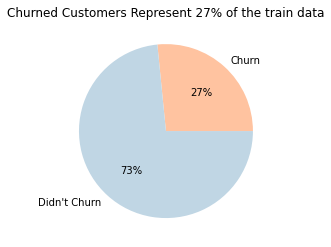

In [7]:
#show percentage of customers who churned from the train data
e.churn_percentage(train)

**A little over 1/4 of customers in the training data churn.**

## 2. Does a customer's tenure affect churn? 

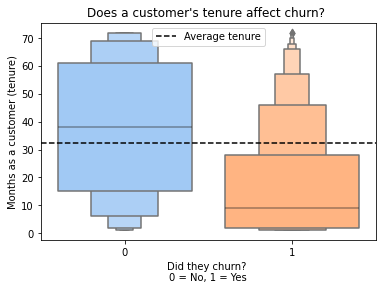

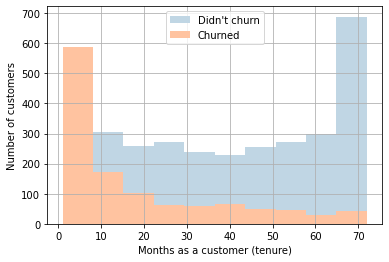

In [8]:
#plot tenure of those who churned and didn't churn
e.tenure_viz(train)

**It looks like those who have been a customer a shorter amount of time churn more**

**In order to confirm this prediction, I will now do a T-test to test for a significant difference between tenure of those who churn and don't churn**
* My confidence interval is 95%
* Resulting alpha is .05

In [9]:
alpha = 0.05

**To run a T-test we have to check our assumptions**
* **Independent:** Yes. Two separate groups churn and no_churn
* **Normal distribution:** Yes. Enough observations
* **Equal variances:** Check $\Downarrow$

In [10]:
stats.levene(train_churn.tenure, train_no_churn.tenure)

LeveneResult(statistic=279.0983604857994, pvalue=7.303234343977914e-61)

pvalue < alpha so they are NOT equal and we must use equal_var = False

**Set Hypothesis**

$H_0$ = There is no difference in tenure between those who churn and don't churn 

$H_a$ = There is a difference in tenure between those who churn and don't churn 

In [11]:
tstat, p = stats.ttest_ind(train_churn.tenure, train_no_churn.tenure, equal_var= False)

In [12]:
if (p < alpha):
    print(f"tstat: {tstat}\np-value: {p}\np < alpha, so we can reject the null hypothesis and say there is probably a difference in tenure between those who churn and don't churn.")
else:
    print(f"tstat: {tstat}\np-value: {p}\np > alpha, so we fail to reject the null hypothesis and say there is no difference in tenure between those who churn and don't churn.")

tstat: -29.127546311454513
p-value: 6.457343935652863e-162
p < alpha, so we can reject the null hypothesis and say there is probably a difference in tenure between those who churn and don't churn.


**Based on the visualizations and the results from the T-test, I think that tenure should be used in my model to help with the model's accuracy.**

## 3. Do higher monthly charges affect churn?

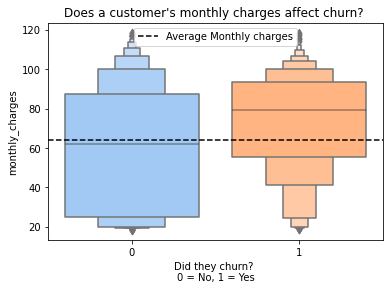

In [13]:
e.monthly_charges_viz(train)

**It looks like those who churn have higher monthly charges**

**In order to confirm this prediction, I will now do a T-test to test if monthly charges of those who churn are higher than those who don't churn**
* My confidence interval is 95%
* Resulting alpha is .05

**To run a T-test we have to check our assumptions**
* **Independent:** Yes. Two separate groups churn and no_churn
* **Normal distribution:** Yes. Enough observations
* **Equal variances:** Check $\Downarrow$

In [14]:
stats.levene(train_churn.monthly_charges, train_no_churn.monthly_charges)

LeveneResult(statistic=248.35641580913386, pvalue=1.5798656854889806e-54)

pvalue < alpha so they are NOT equal and we must use equal_var = False

$H_0$ = Monthly charges of those who churn $\leq$ monthly charges of those who don't churn

$H_a$ = Monthly charges of those who churn $>$ monthly charges of those who don't churn

In [15]:
tstat, p = stats.ttest_ind(train_churn.monthly_charges, train_no_churn.monthly_charges, equal_var= False)

In [16]:
if (p/2 < alpha):
    print(f"tstat: {tstat}\np-value: {p}\np/2 < alpha, so we can reject the null hypothesis and say monthly charges of those who churn are higher than those who don't churn.")
else:
    print(f"tstat: {tstat}\np-value: {p}\np > alpha, so we fail to reject the null hypothesis and say monthly charges of those who churn are not higher than those who don't churn.")

tstat: 14.538647732040117
p-value: 3.646511386011469e-46
p/2 < alpha, so we can reject the null hypothesis and say monthly charges of those who churn are higher than those who don't churn.


**Based on the visualizations and the results from the T-test, I think that monthly charges should be used in my model to help with the model's accuracy.**

## 4. Does contract type affect churn?

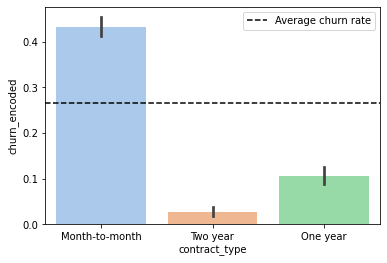

In [17]:
sns.barplot(x="contract_type", y="churn_encoded", data=train, palette='pastel')
rate = train["churn_encoded"].mean()
plt.axhline(rate, label = f'Average churn rate', linestyle='--', color='black')
plt.legend()
plt.show()

**It looks like those who have a month-to-month contract churn well above the average churn rate. I predict there is a relationship between contract type and churn**

**In order to confirm this prediction, I will now do a $\chi^2$ test to check if there is a relationship between contract type and churn**
* My confidence interval is 95%
* Resulting alpha is .05

$H_0$ = Contract type and churn are not related.

$H_a$ = Contract type and churn are related.

In [18]:
observed = pd.crosstab(train["contract_type"], train["churn_encoded"])
observed

churn_encoded,0,1
contract_type,,
Month-to-month,1417,1081
One year,866,103
Two year,1074,31


In [19]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [20]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1417 1081]
 [ 866  103]
 [1074   31]]
---
Expected

[[1834.16141732  663.83858268]
 [ 711.49015748  257.50984252]
 [ 811.3484252   293.6515748 ]]
---

chi^2 = 803.2392
p     = 0.0000


In [21]:
if (p < alpha):
    print(f"χ^2: {chi2}\np-value: {p}\np/2 < alpha, we can reject the null hypothesis and say there is evidence that contract type and churn are related.")
else:
    print(f"χ^2: {chi2}\np-value: {p}\np/2 > alpha, we fail to reject the null hypothesis and say there is not enough evidence to show contract type and churn are related.")
    
    

χ^2: 803.2391996099897
p-value: 3.7916127980609574e-175
p/2 < alpha, we can reject the null hypothesis and say there is evidence that contract type and churn are related.


**Based on the visualizations and the results from the $\chi^2$ test, I think that contract type should be used in my model to help with the model's accuracy.**

## 5. Do those with no tech support churn more?

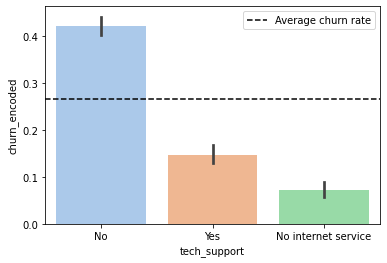

In [22]:
sns.barplot(x="tech_support", y="churn_encoded", data=train, palette='pastel')
rate = train["churn_encoded"].mean()
plt.axhline(rate, label = f'Average churn rate', linestyle='--', color='black')
plt.legend()
plt.show()

**It looks like those who don't have tech suport might churn more. I predict there is a relationship between having tech support and churn**

$H_0$ = There is no relationship between having tech support and churn.

$H_a$ = There is a relationship between having tech support and churn.

**Independent:** Yes. Two separate groups churn and no_churn

**Normal distribution:** Yes. Enough observations

**Equal variances:** Check $\Downarrow$

In [23]:
observed = pd.crosstab(train["tech_support"], train["churn_encoded"])
observed

churn_encoded,0,1
tech_support,,
No,1310,952
No internet service,946,73
Yes,1101,190


In [24]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [25]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2}')
print(f'p     = {p}')

Observed

[[1310  952]
 [ 946   73]
 [1101  190]]
---
Expected

[[1660.87795276  601.12204724]
 [ 748.20275591  270.79724409]
 [ 947.91929134  343.08070866]]
---

chi^2 = 568.727323866529
p     = 3.1800267159444295e-124


In [26]:
if (p < alpha):
    print(f"χ^2: {chi2}\np-value: {p}\np/2 < alpha, we can reject the null hypothesis and say there is evidence that tech support and churn are related.")
else:
    print(f"χ^2: {chi2}\np-value: {p}\np/2 > alpha, we fail to reject the null hypothesis and say there is not enough evidence to show tech support and churn are related.")


χ^2: 568.727323866529
p-value: 3.1800267159444295e-124
p/2 < alpha, we can reject the null hypothesis and say there is evidence that tech support and churn are related.


**Based on the visualizations and the results from the $\chi^2$ test, I think that tech support should be used in my model to help with the model's accuracy.**

### Exploration Summary
* Tenure seems to be a driver of churn
* Monthly_charges seem to be a driver of churn
* Contract_type seems to be a driver of churn
* Tech_support seems to be a driver of churn

### Features I'm moving on with
| Feature | Reason | 
|:--------|:-----------|
|tenure| From our t-test we saw there is probably a difference in tenure between those who churn and don't churn.|
|monthly_charges| From our t-test we saw there is probably a difference in monthly charges between those who churn and don't churn.|
|contract_type| From our $\chi^2$ test we saw there is probably a relationship between contract type and churn.|
|tech_support| From our $\chi^2$ test we saw there is probably a relationship between contract type and churn.|

In [27]:
drivers =['churn_encoded', 'contract_type', 'monthly_charges', 'tenure', 'tech_support']

### Features I'm not moving on with

| Feature | Reason | 
|:--------|:-----------|
|gender| No evidence that gender is a driver of churn
|senior_citizen| No evidence that senior_citizen is a driver of churn
|partner| No evidence that partner is a driver of churn
|dependents| No evidence that dependents is a driver of churn
|phone_service| No evidence that phone_service is a driver of churn
|multiple_lines| No evidence that multiple_lines is a driver of churn
|online_security| No evidence that online_security is a driver of churn
|online_backup| No evidence that online_backup is a driver of churn
|device_protection| No evidence that device_protection is a driver of churn
|streaming_tv| No evidence that streaming_tv is a driver of churn
|streaming_movies| No evidence that streaming_movies is a driver of churn
|paperless_billing| No evidence that paperless_billing is a driver of churn
|total_charges| There is a strong correlation between total_charges and tenure and between total_charges and monthly_charges. Since I will take tenure and monthly_charges into my model, total_charges is not needed.
|internet_service_type| No evidence that internet_service_type is a driver of churn
|payment_type| No evidence that payment_type is a driver of churn


# Modeling

* I will use accuracy as my evaluation metric
* I had looked at recall, but we cannot determine that false negatives are more costly unless we get more information from the company.
* Didn't churn customers make up 73% of the train data

In [28]:
X_train, y_train, X_validate, y_validate, X_test, y_test = w.prep_for_model(train, validate, test, "churn_encoded", drivers)

In [29]:
#baseline based on the percentage of the mode
baseline = y_train.value_counts(normalize=True).max()
print(f'Baseline accuracy: {baseline:.2%}')

Baseline accuracy: 73.43%


### Model Testing
* I evaluated on the four different model types and various hyperparameter configurations below
* Models were evaluated on train and validate data to prevent overfitting
* The model that performed the best was then run on the test data

### Decision Tree

In [30]:
# Decision tree  
# create classifier object
clf = DecisionTreeClassifier(max_depth=4, random_state=27)

#fit model on training data
clf.fit(X_train, y_train)

#print results
print("Decision Tree")
print(f"Train Accuracy: {clf.score(X_train, y_train):.2%}")
print(f"Validate Accuracy: {clf.score(X_validate, y_validate):.2%}")
print(f"Difference: {(clf.score(X_train, y_train)-clf.score(X_validate, y_validate)):.2%}")

Decision Tree
Train Accuracy: 79.57%
Validate Accuracy: 78.08%
Difference: 1.49%


### Random Forest

In [31]:
#Random forest 
# create classifier object
rf = RandomForestClassifier(max_depth=4, random_state=27)

#fit model on training data
rf.fit(X_train, y_train)

#print results
print('Random Forest')
print(f"Train Accuracy: {rf.score(X_train, y_train):.2%}")
print(f"Validate Accuracy: {rf.score(X_validate, y_validate):.2%}")
print(f"Difference: {(rf.score(X_train, y_train)-rf.score(X_validate, y_validate)):.2%}")

Random Forest
Train Accuracy: 79.75%
Validate Accuracy: 78.79%
Difference: 0.96%


### KNN

In [32]:
#KNN 
# create classifier object
knn = KNeighborsClassifier()

#fit model on training data
knn.fit(X_train, y_train)

#print results
print('KNN')
print(f"Train Accuracy: {knn.score(X_train, y_train):.2%}")
print(f"Validate Accuracy: {knn.score(X_validate, y_validate):.2%}")
print(f"Difference: {(knn.score(X_train, y_train)-knn.score(X_validate, y_validate)):.2%}")

KNN
Train Accuracy: 84.43%
Validate Accuracy: 75.59%
Difference: 8.84%


### Logistic Regression

In [33]:
#Logistic regression 
# create classifier object
logit = LogisticRegression(random_state=27)

#fit model on training data
logit.fit(X_train, y_train)

#print results
print('Logistic Regression')
print(f"Train Accuracy: {logit.score(X_train, y_train):.2%}")
print(f"Validate Accuracy: {logit.score(X_validate, y_validate):.2%}")
print(f"Difference: {(logit.score(X_train, y_train)-logit.score(X_validate, y_validate)):.2%}")

Logistic Regression
Train Accuracy: 78.63%
Validate Accuracy: 79.36%
Difference: -0.73%


### Comparing Models
* All models perfomed better than baseline for both train and validate data.
* KNN had a high train accuracy and lower validate accuracy so it is probably over fit.

### Best model: Random Forest Model 
* I chose the random forest model because the difference in accuracy between the train and validate is less than 1%
* I will now run the random forest model on test data to gauge how it will perform on future data

In [34]:
#run the best overall model on test data
print('Best Model: Random Forest')
print(f"Test Accuracy: {rf.score(X_test, y_test):.2%}")

Best Model: Random Forest
Test Accuracy: 78.20%


**This model performs better than baseline and with very similar accuracy across all three data sets (train, validate and test).**

In [35]:
#print results
print('Random Forest')
print(f"Train Accuracy: {rf.score(X_train, y_train):.2%}")
print(f"Validate Accuracy: {rf.score(X_validate, y_validate):.2%}")
print(f"Test Accuracy: {rf.score(X_test, y_test):.2%}")

Random Forest
Train Accuracy: 79.75%
Validate Accuracy: 78.79%
Test Accuracy: 78.20%


## Conclusion

### Summary
* About 1/4 of our customers churn
* Tenure seems to be a driver of churn
* Monthly_charges seem to be a driver of churn
* Contract_type seems to be a driver of churn
* Tech_support seems to be a driver of churn


### Recommendations
* To reduce churn, I would encourage the company to think about taking the following actions:
    * Seek out young customers and give discounts (lower monthly cost) in order to keep customers longer (increase tenure)
    * Seek out month-to-month contract customers and encourage them to sign a longer contract maybe through discounts
    * Seek out those who don't have tech support and give a free trial of tech support.

### Next Steps
* In the next iteration:
    * Look into how customers with internet add-ons are the same people then can see if they churn more or less.
    * Look into cost of add-ons and see if there are bundles that might reduce monthly charges. That could help us entice more customers to stay.

A Predictions (.csv).

3 columns: customer_id, probability of churn, and prediction of churn. (1=churn, 0=not_churn).

These predictions should be from your best performing model ran on X_test.

Note that the order of the y_pred and y_proba are numpy arrays coming from running the model on X_test. The order of those values will match the order of the rows in X_test, so you can obtain the customer_id from X_test and concatenate these values together into a dataframe to write to CSV.